## Сравнение байесовской и частотной регрессии

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import norm

wine_df = pd.read_csv("winequality-red.csv", sep=';')


In [3]:
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


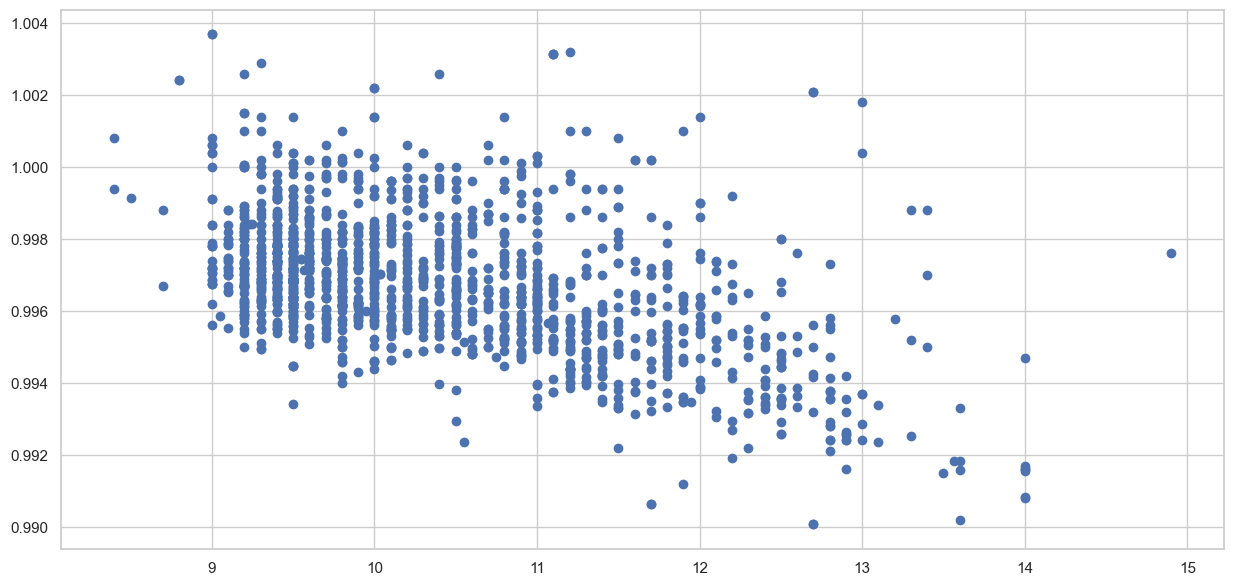

In [21]:
plt.figure(figsize=(15,7))
#sns.lineplot(data=wine_df, x="alcohol",y="density")
plt.scatter(wine_df["alcohol"], wine_df["density"])

Принятое 'истинное' значение коэффициента (beta_true): -0.4962
Оцененная дисперсия шума (sigma^2): 0.7538


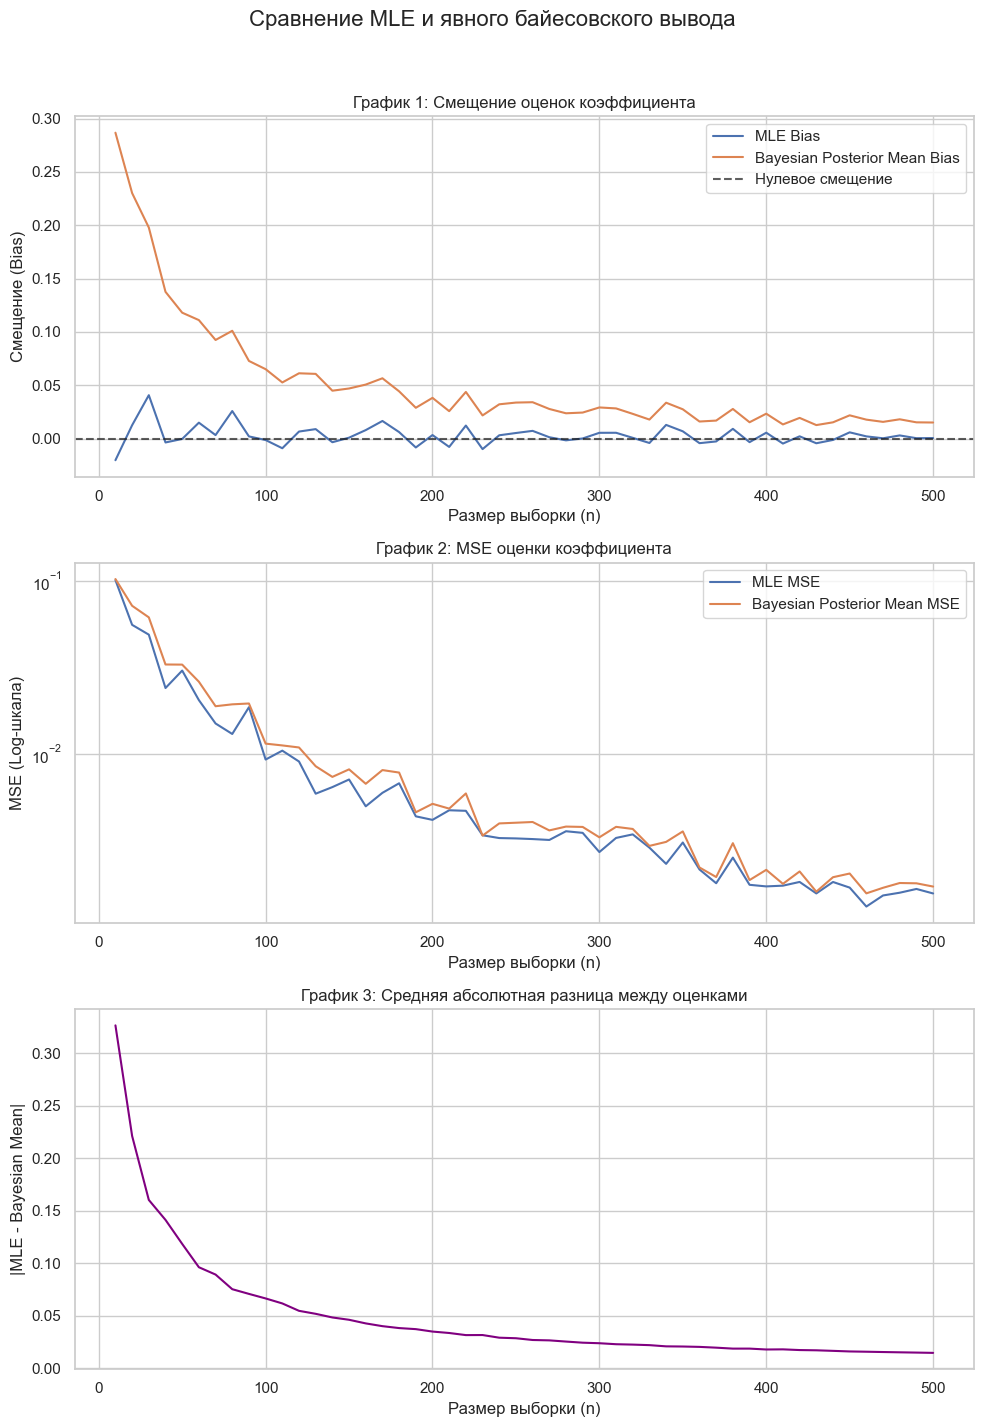

In [22]:
X = wine_df[['alcohol']].values
y = wine_df['density'].values

# Стандартизация данных
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

full_data_model = LinearRegression(fit_intercept=False)
full_data_model.fit(X_scaled, y_scaled)
beta_true = full_data_model.coef_[0]

residuals = y_scaled - full_data_model.predict(X_scaled)
noise_var = np.var(residuals)
noise_precision = 1.0 / noise_var 

prior_precision = 20.0 # alpha
prior_var = 1.0 / prior_precision
prior_std = np.sqrt(prior_var)

print(f"Принятое 'истинное' значение коэффициента (beta_true): {beta_true:.4f}")
print(f"Оцененная дисперсия шума (sigma^2): {noise_var:.4f}")


# --- 3. Наша байесовская функция ---
def bayesian_posterior_mean(X, y, prior_prec, noise_prec):
    """
    Вычисляет среднее апостериорного распределения для весов w.
    """
    d = X.shape[1]    
    # S_N_inv = (alpha*I + beta*X^T*X) Апостериорная ковариация
    S_N_inv = prior_prec * np.identity(d) + noise_prec * X.T @ X
    
    # S_N = (alpha*I + beta*X^T*X)^-1
    S_N = np.linalg.inv(S_N_inv + 1e-6 * np.identity(d))
    
    # m_N = beta * S_N * X^T * y Апостериорное среднее
    m_N = noise_prec * S_N @ X.T @ y
    
    return m_N

num_simulations = 100
sample_sizes = np.arange(10, 501, 10)
results = {'mle_bias': [], 'map_bias': [], 'mle_mse': [], 'map_mse': [], 'estimates_diff': []}
total_indices = np.arange(len(X_scaled))

for n in sample_sizes:
    mle_coefs, map_coefs = [], []
    for _ in range(num_simulations):
        sample_indices = np.random.choice(total_indices, size=n, replace=False)
        X_sample, y_sample = X_scaled[sample_indices], y_scaled[sample_indices]
        
        # Частотная модель (MLE)
        mle_model = LinearRegression(fit_intercept=False).fit(X_sample, y_sample)
        mle_coefs.append(mle_model.coef_[0])
        
        # Байесовская модель
        m_N = bayesian_posterior_mean(X_sample, y_sample, prior_precision, noise_precision)
        map_coefs.append(m_N[0])

    # Вычисляем и сохраняем метрики
    mle_coefs, map_coefs = np.array(mle_coefs), np.array(map_coefs)
    results['mle_bias'].append(np.mean(mle_coefs - beta_true))
    results['map_bias'].append(np.mean(map_coefs - beta_true))
    results['mle_mse'].append(mean_squared_error(np.full_like(mle_coefs, beta_true), mle_coefs))
    results['map_mse'].append(mean_squared_error(np.full_like(map_coefs, beta_true), map_coefs))
    results['estimates_diff'].append(np.mean(np.abs(mle_coefs - map_coefs)))

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
fig.suptitle('Сравнение MLE и явного байесовского вывода', fontsize=16)

axes[0].plot(sample_sizes, results['mle_bias'], label='MLE Bias')
axes[0].plot(sample_sizes, results['map_bias'], label='Bayesian Posterior Mean Bias')
axes[0].axhline(0, color='k', linestyle='--', alpha=0.7, label='Нулевое смещение')
axes[0].set_title('График 1: Смещение оценок коэффициента')
axes[0].set_xlabel('Размер выборки (n)')
axes[0].set_ylabel('Смещение (Bias)')
axes[0].legend()

axes[1].plot(sample_sizes, results['mle_mse'], label='MLE MSE')
axes[1].plot(sample_sizes, results['map_mse'], label='Bayesian Posterior Mean MSE')
axes[1].set_title('График 2: MSE оценки коэффициента')
axes[1].set_xlabel('Размер выборки (n)')
axes[1].set_ylabel('MSE (Log-шкала)')
axes[1].set_yscale('log')
axes[1].legend()

axes[2].plot(sample_sizes, results['estimates_diff'], color='purple')
axes[2].set_title('График 3: Средняя абсолютная разница между оценками')
axes[2].set_xlabel('Размер выборки (n)')
axes[2].set_ylabel('|MLE - Bayesian Mean|')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

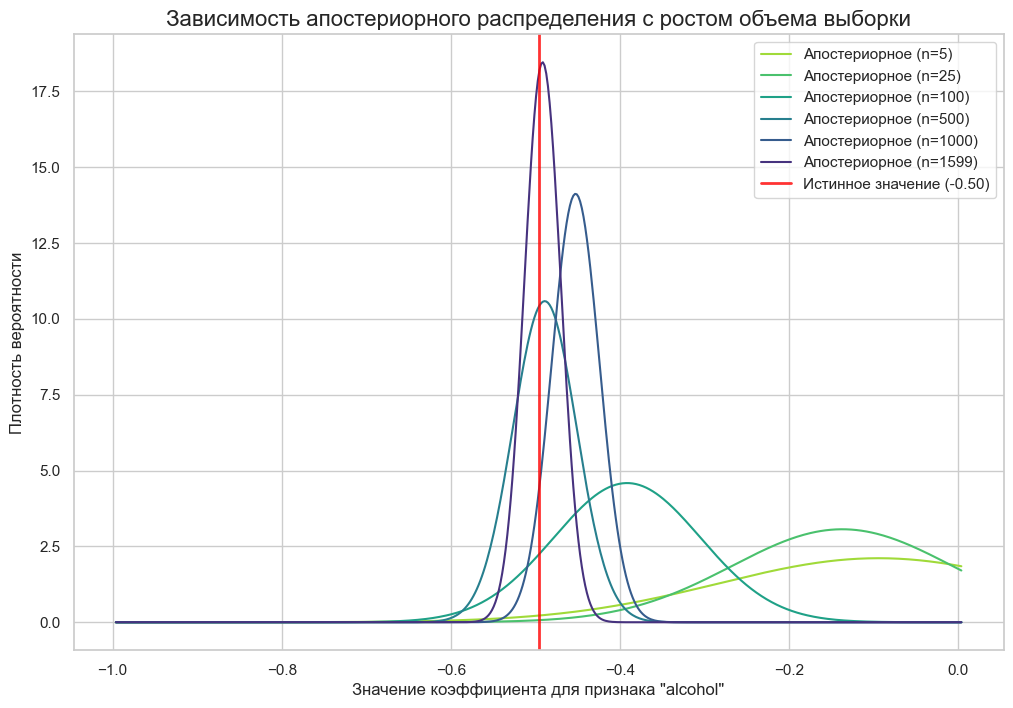

In [17]:
def calculate_posterior_params(X, y, prior_prec, noise_prec):
    """
    Вычисляет среднее и дисперсию апостериорного распределения.
    """
    d = X.shape[1]
    S_N_inv = prior_prec * np.identity(d) + noise_prec * X.T @ X
    S_N = np.linalg.inv(S_N_inv + 1e-8 * np.identity(d)) # Апостериорная ковариация
    m_N = noise_prec * S_N @ X.T @ y                   # Апостериорное среднее
    return m_N, S_N

# --- 4. Визуализация ---
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 8))
x_vals = np.linspace(beta_true - 0.5, beta_true + 0.5, 500)

sample_sizes_to_plot = [5, 25, 100, 500,1000,len(X_scaled)]
colors = sns.color_palette("viridis_r", n_colors=len(sample_sizes_to_plot))
total_indices = np.arange(len(X_scaled))
for i, n in enumerate(sample_sizes_to_plot):
    if n < len(X_scaled):
        sample_indices = np.random.choice(total_indices, size=n, replace=False)
    else:
        sample_indices = total_indices
        
    X_sample, y_sample = X_scaled[sample_indices], y_scaled[sample_indices]
    
    m_N, S_N = calculate_posterior_params(X_sample, y_sample, prior_precision, noise_precision)
    
    posterior_mean = m_N[0]
    posterior_var = S_N[0, 0]
    posterior_std = np.sqrt(posterior_var)
    
    
    posterior_pdf = norm.pdf(x_vals, posterior_mean, posterior_std)
    ax.plot(x_vals, posterior_pdf, color=colors[i], 
            label=f'Апостериорное (n={n})')
ax.axvline(beta_true, color='red', linestyle='-', lw=2, alpha=0.8, 
           label=f'Истинное значение ({beta_true:.2f})')


ax.set_title('Зависимость апостериорного распределения с ростом объема выборки', fontsize=16)
ax.set_xlabel('Значение коэффициента для признака "alcohol"')
ax.set_ylabel('Плотность вероятности')
ax.legend()
plt.show()